# SVHN Projektarbeit

# Experiment

## wichtige Pakete einlesen

gegebenenfalls müssen die Pakete (v.a. im Jupyter Hub) zunächst installiert werden, bevor sie importiert werden können

In [70]:
!pip install scipy
!pip install torchvision
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install torchsummary
!pip install pandas
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [185]:
import math                     # Mathematische Funktionen wie sqrt, ceil, pi, etc.
import matplotlib.pyplot as plt # Plotten von Graphen, Bildern, Trainingskurven
import numpy as np              # Numerische Operationen auf Arrays, Matrizen, Vektoren
import os                       # Betriebssystem-Funktionen: Pfade, Dateien, Verzeichnisse
import pandas as pd             # Datenanalyse, Tabellen und DataFrames
import random                   # Erzeugung von Zufallszahlen, Shuffling, Seed-Kontrolle
import scipy.io                 # Lesen und Schreiben von MATLAB .mat-Dateien
import seaborn as sns           # Hochwertige Visualisierungen und Heatmaps
import time                     # Zeitmessung, Verzögerungen, Zeitstempel
import torch                    # Hauptframework PyTorch für Deep Learning (Tensors, Autograd, Modelle)
import torchvision              # Bibliothek für Standard-Datasets, vortrainierte Modelle, Bildtransformationen
import torchvision.transforms as transforms
                                # Transformationen für Bilder: ToTensor, Normalisierung, Resizing
import torch.nn as nn           # Bausteine für neuronale Netze: Layer wie Conv2d, Linear, ReLU
import torch.nn.functional as F # Funktionale API für Aktivierungsfunktionen, Losses, etc. (z.B. F.relu)
import torch.optim as optim     # Optimizer für das Training (SGD, Adam, etc.)

from collections import Counter                     # Zählen von Elementen in iterierbaren Objekten
from sklearn.metrics import classification_report   # Berechnung von Precision, Recall, F1-Score
from sklearn.metrics import confusion_matrix        # Erstellung von Confusion Matrices
from torchsummary import summary                    # Übersicht über Modelle: Layer, Parametrisierung
from torch.utils.data import DataLoader, Dataset    # Dataset: Basis für eigene Datensätze; DataLoader: Batch & Shuffle
from torchvision import datasets, transforms        # Standard-Datasets (MNIST, SVHN etc.) + Bildtransformationen


## Daten

### Daten über torchvision

Für unseren Datensatz gibt es zwei Wege die Daten sinnvoll im Notebook zu hinterlegen. Tatsächlich gibt es diesen Datensatz im Paket torchvision und kann direkt per Code heruntergeladen werden. Das ist vor allem dann sinnvoll, wenn der Datensatz auf dem lokalen Gerät nicht zur Verfügung steht. Es bietet aber außerdem den Vorteil, dass man damit besser über github arbeiten kann, da dort die Daten über 100MB nicht hochgeladen werden können. Zur Vollständigkeit ist aber dennoch der Code zum einlesen der Daten darunter.

In [72]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Train-Set
train_dataset = datasets.SVHN(
    root="data",
    split='train',      # 'train' = train_32x32.mat
    download=True,      # lädt automatisch herunter, wenn nicht vorhanden
    transform=transform
)

# Test-Set
test_dataset = datasets.SVHN(
    root="data",
    split='test',       # 'test' = test_32x32.mat
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


### Daten über seine eigene os

In dieser Zelle wird eine **PyTorch Dataset-Klasse** für den SVHN-Datensatz definiert.

- **Zweck:** Ermöglicht es, `.mat`-Dateien mit Bildern und Labels einfach in PyTorch zu laden und in Batches zu verarbeiten.
- **Funktionen:**
  - `__init__`: Lädt die Daten aus der `.mat`-Datei und speichert optionale Transformationen.
  - `__len__`: Gibt die Anzahl der Bilder zurück (wichtig für DataLoader).
  - `__getitem__`: Liefert ein einzelnes Bild und Label als Tensor, normalisiert die Pixel und wendet Transformationen an.
- **Besonderheiten:**
  - Pixelwerte werden von [0,255] auf [0,1] normalisiert.
  - SVHN Label „10“ wird in `0` umgewandelt.
  - PyTorch erwartet die Kanal-Reihenfolge `(C,H,W)`, daher wird das Bild umgeformt.


In [116]:
class SVHNDataset(Dataset):
    # Wir erben von torch.utils.data.Dataset, damit PyTorch den DataLoader nutzen kann

    def __init__(self, mat_file, transform=None):
        # Konstruktor: Lädt die .mat-Datei und initialisiert Variablen
        data = scipy.io.loadmat(mat_file)   # scipy.io.loadmat: lädt MATLAB-Dateien
        self.X = data['X']                  # X enthält die Bilder: shape (32, 32, 3, N)
        self.y = data['y'].flatten()        # y enthält Labels: shape (N,). flatten() macht aus Spaltenvektor 1D-Array
        self.transform = transform          # Transformationsobjekt für Bildvorverarbeitung (optional)

        # SVHN-Spezialfall: Label "10" bedeutet Ziffer "0"
        self.y[self.y == 10] = 0

    def __len__(self):
        # Gibt die Anzahl der Samples zurück, damit DataLoader weiß, wie viele es gibt
        return self.X.shape[3]              # N = Anzahl Bilder

    def __getitem__(self, idx):
        # Liefert ein einzelnes Sample (Bild + Label) für Index idx
        img = self.X[:,:,:,idx]             # Bild: (32,32,3)
        # torch.tensor: konvertiert numpy-array zu Tensor
        # permute(2,0,1): PyTorch erwartet Kanal zuerst (C,H,W) statt H,W,C
        # float()/255.0: normalisiert Pixelwerte von [0,255] auf [0,1]
        img = torch.tensor(img).permute(2,0,1).float()/255.0
        label = int(self.y[idx])            # Label als Integer

        if self.transform:
            img = self.transform(img)       # Falls Transform gesetzt, anwenden (z.B. RandomCrop, Normalize)

        return img, label                     # Rückgabe: Tensorbild + Label


In [ ]:
transform = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

train_dataset = SVHNDataset('train_32x32.mat', transform=transform)
test_dataset  = SVHNDataset('test_32x32.mat',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


### Beispiel der Trainingsdaten


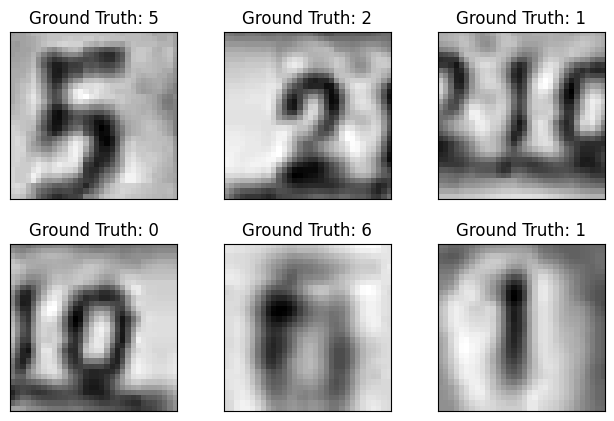

In [73]:
# Iterator über den Test-DataLoader erstellen
examples = enumerate(test_loader)

# Den ersten Batch aus dem Test-DataLoader holen
batch_idx, (example_data, example_targets) = next(examples)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# 6 Bilder aus dem Batch plotten
for i in range(6):
    # Unterteilt die Figur in 2x3 Raster, i+1 = aktuelle Position
    plt.subplot(2, 3, i+1)
    plt.tight_layout()  # Sorgt dafür, dass Plots sich nicht überlappen
    # Zeige das Bild an; example_data[i][0] = 1. Kanal (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    # Titel mit Ground-Truth-Label
    plt.title("Ground Truth: {}".format(example_targets[i]))
    # Achsenbeschriftungen entfernen
    plt.xticks([])
    plt.yticks([])

# Alle geplotteten Bilder anzeigen
plt.show()


## klassisches neuronales Netz

### Definition des CNN-Modells

In dieser Zelle wird die Klasse `Net` definiert, die ein Convolutional Neural Network (CNN) implementiert.

- **Zweck:** Definiert die Architektur des neuronalen Netzes für Bilderkennung.
- **Aufbau:**
  1. Convolutional Layer (Feature Extraction)
  2. Max-Pooling (Reduzierung der Dimensionen)
  3. ReLU (Nichtlinearität)
  4. Dropout (Regularisierung)
  5. Flatten (Umwandlung in 1D für Fully Connected Layer)
  6. Fully Connected Layer(s) (klassische Klassifizierung)
  7. Softmax (Wahrscheinlichkeitsausgabe für Klassen)
- **TODO-Liste im Kommentar:** Zeigt, welche Layer du für ein vollständiges CNN einbauen solltest.


In [74]:
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)

# CNN-Klasse definieren
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- Erster Convolutional Layer ---
        # nn.Conv2d: 2D Convolution
        # 3 Input-Kanäle (RGB), 10 Output-Kanäle (Features), Kernelgröße 5x5
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  # TODO: ggf. auf 1 Input-Kanal anpassen für Graustufen

        # Dropout für die Convolutionen (reduziert Overfitting)
        self.drop = nn.Dropout2d()

        # Fully Connected Layer
        # nn.Linear: verbindet alle Eingangseinheiten mit allen Ausgangseinheiten
        # 1960 Eingangsdimensionen → 1000 Ausgangsdimensionen (muss evtl. an tatsächliche Flatten-Größe angepasst werden)
        self.fc1 = nn.Linear(1960, 1000)

    # --- Forward-Pass ---
    def forward(self, x):
        x = self.conv1(x)               # 1. Convolution
        x = self.drop(x)                # 2. Dropout
        x = F.max_pool2d(x, 2)          # 3. Max-Pooling über 2x2
        x = F.relu(x)                   # 4. ReLU-Aktivierung
        x = x.flatten(1)                # 5. Flattening: CxHxW → 1D für Fully Connected Layer
        x = self.fc1(x)                 # 6. Fully Connected Layer
        x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe
        return x                        # Rückgabe: Log-Wahrscheinlichkeiten pro Klasse

In [75]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Initialisierung des Modells, der Gewichte und des Optimizers

In dieser Zelle wird das neuronale Netz erstellt, seine Gewichte initialisiert und der Optimizer definiert.

- `model = Net()`: Erstellt eine Instanz des zuvor definierten CNN-Modells.
- `model.apply(weights_init)`: Wendet eine eigene Initialisierungsfunktion (`weights_init`) auf alle Layer des Modells an.
  Dies sorgt dafür, dass die Anfangsgewichte der Layer sinnvoll gesetzt werden, was das Lernen stabiler und schneller macht.
- `optim.SGD(...)`: Erstellt einen Stochastic Gradient Descent Optimizer.
  - `model.parameters()`: Übergibt die trainierbaren Parameter des Modells.
  - `lr=0.01`: Lernrate.
  - `momentum=0.5`: Verbessert die Konvergenzgeschwindigkeit, indem vorherige Gradienten berücksichtigt werden.


In [76]:
# Erstellt eine Instanz des CNN-Modells (Klasse Net aus vorheriger Zelle)
model = Net()

# Initialisiert die Gewichte aller Layer mit einer benutzerdefinierten Funktion weights_init
# Dadurch starten die Gewichte nicht zufällig schlecht, was Training verbessern kann
model.apply(weights_init)

# Definiert den Optimizer: Stochastic Gradient Descent
# model.parameters(): alle trainierbaren Parameter des Modells
# lr=0.01: Lernrate
# momentum=0.5: hilft, "Schwankungen" im Gradienten auszugleichen
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


### Trainingsroutine

In dieser Zelle wird die Trainingsfunktion `train(epoch)` definiert.
Sie führt einen kompletten Trainingsdurchlauf (Epoch) über den gesamten Trainingsdatensatz aus.

Ablauf:
1. `model.train()`: Schaltet das Modell in den Trainingsmodus (aktiviert z.B. Dropout).
2. Schleife über alle Batches im `train_loader`.
3. `optimizer.zero_grad()`: Setzt Gradienten des vorherigen Backpropagation-Schritts zurück.
4. `output = model(data)`: Modellvorhersage für den aktuellen Batch.
5. `loss = F.nll_loss(...)`: Berechnet die Negative Log-Likelihood Loss (passend für `log_softmax`).
6. `loss.backward()`: Backpropagation – berechnet Gradienten.
7. `optimizer.step()`: Aktualisiert die Modellparameter.
8. Alle 10 Batches wird der aktuelle Trainingsfortschritt (Loss) ausgegeben.


In [77]:
# Haupt-Trainingsroutine
def train(epoch):
    model.train()  # Modell in den Trainingsmodus setzen (Dropout aktiv, BatchNorm aktiviert)

    # Schleife über alle Batches im Training DataLoader
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()       # Vor jedem Schritt Gradienten zurücksetzen

        output = model(data)        # Modellvorhersage für aktuellen Batch
        loss = F.nll_loss(output, target)  # Loss berechnen (für log_softmax geeignet)

        loss.backward()             # Backpropagation: Gradienten berechnen
        optimizer.step()            # Parameter-Update mittels Optimizer

        # Fortschrittsanzeige alle 10 Batches
        if batch_idx % 10 == 0:
            print(
                'Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch,                          # Aktuelle Epoche
                    batch_idx * len(data),          # Anzahl verarbeiteter Trainingsbeispiele
                    len(train_loader.dataset),      # Gesamtzahl der Trainingsdaten
                    loss.item()                     # Aktueller Loss-Wert
                )
            )


### Test-/Evaluierungsroutine

In dieser Zelle wird die Funktion `test()` definiert, die das Modell auf den Testdaten auswertet.

Ablauf:
1. `model.eval()`: Setzt das Modell in den Evaluierungsmodus
   (Dropout deaktiviert, BatchNorm verwendet Durchschnittswerte).
2. `torch.no_grad()`: Deaktiviert Gradientenberechnung – spart Zeit und Speicher.
3. Schleife über `test_loader`:
   - Modellvorhersagen berechnen
   - Loss aufsummieren (für Durchschnitt am Ende)
   - Vorhersagen mit den Zielwerten vergleichen → Accuracy
4. Nach der Schleife:
   - Durchschnitts-Loss berechnen
   - Genauigkeit berechnen und ausgeben


In [78]:
# Testfunktion, um das Modell auf den Testdaten auszuwerten
def test():
    model.eval()      # Modell in den Evaluierungsmodus setzen (Dropout aus)
    test_loss = 0     # Summe der Loss-Werte
    correct = 0       # Anzahl korrekter Vorhersagen

    # Im Testmodus keine Gradienten berechnen → schneller und spart Speicher
    with torch.no_grad():
        # Schleife über alle Test-Batches
        for data, target in test_loader:

            output = model(data)  # Modellvorhersage

            # Addiere den Loss des Batches (size_average=False = Summe statt Mittelwert)
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Wähle die Klasse mit der höchsten Wahrscheinlichkeit
            pred = output.data.max(1, keepdim=True)[1]

            # Vergleiche Vorhersagen mit dem Ground-Truth
            correct += pred.eq(target.data.view_as(pred)).sum()

    # Durchschnittlichen Loss berechnen
    test_loss /= len(test_loader.dataset)

    # Ergebnisse ausgeben
    print(
        '\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

### Ausführen des Trainings und Testens über mehrere Epochen

In dieser Zelle wird zuerst die Anfangsleistung des Modells auf den Testdaten berechnet („untrainiertes Modell“).
Anschließend wird das Modell über mehrere Epochen trainiert. Nach jeder Epoche wird erneut getestet, um den Fortschritt zu messen.

Ablauf:
1. `test()`: Bewertung des Modells vor dem Training (Baseline).
2. `n_epochs = 3`: Anzahl der Trainingsdurchläufe (Epochen).
3. Schleife über alle Epochen:
   - `train(epoch)`: Trainingsdurchlauf über alle Trainingsdaten.
   - `test()`: Bewertung der Modellleistung nach dieser Epoche.


In [79]:
# Anfangsleistung des Modells testen (ungelerntes Modell)
test()

# Anzahl der Trainings-Epochen festlegen
n_epochs = 3

# Trainings-/Testschleife über mehrere Epochen
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Modell trainieren
    test()        # Modell nach der Epoche testen


C:\Users\jfdde\AppData\Local\Temp\ipykernel_12588\299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe



Test set: Avg. loss: 6.9712, Accuracy: 0/26032 (0%)

Train Epoch: 1 [0/73257]	Loss: 6.975524
Train Epoch: 1 [640/73257]	Loss: 4.464014
Train Epoch: 1 [1280/73257]	Loss: 3.413445
Train Epoch: 1 [1920/73257]	Loss: 3.175441
Train Epoch: 1 [2560/73257]	Loss: 3.040918
Train Epoch: 1 [3200/73257]	Loss: 2.418230
Train Epoch: 1 [3840/73257]	Loss: 2.703446
Train Epoch: 1 [4480/73257]	Loss: 2.889775
Train Epoch: 1 [5120/73257]	Loss: 2.676010
Train Epoch: 1 [5760/73257]	Loss: 2.709100
Train Epoch: 1 [6400/73257]	Loss: 2.464382
Train Epoch: 1 [7040/73257]	Loss: 2.763069
Train Epoch: 1 [7680/73257]	Loss: 2.605563
Train Epoch: 1 [8320/73257]	Loss: 2.635231
Train Epoch: 1 [8960/73257]	Loss: 2.367254
Train Epoch: 1 [9600/73257]	Loss: 2.471916
Train Epoch: 1 [10240/73257]	Loss: 2.673554
Train Epoch: 1 [10880/73257]	Loss: 2.448528
Train Epoch: 1 [11520/73257]	Loss: 2.442133
Train Epoch: 1 [12160/73257]	Loss: 2.486152
Train Epoch: 1 [12800/73257]	Loss: 2.500619
Train Epoch: 1 [13440/73257]	Loss: 2.21106

### Vorhersagen des trainierten Modells visualisieren

In dieser Zelle wird das Modell auf einige zuvor geladene Beispielbilder angewendet.
Die Predictions (Vorhersagen) werden zusammen mit den Bildern dargestellt.

Ablauf:
1. `output = model(example_data)`: Modell erzeugt Vorhersagen für die ausgewählten Testbilder.
2. `plt.figure()`: Neue Plot-Figur.
3. Schleife über mehrere Bilder:
   - Bild anzeigen (`imshow`)
   - Modellvorhersage ermitteln (`output.data.max(...)`)
   - Prediction als Titel ausgeben
   - Achsen entfernen
4. `plt.show()`: Darstellung der Ergebnisse.


C:\Users\jfdde\AppData\Local\Temp\ipykernel_12588\299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


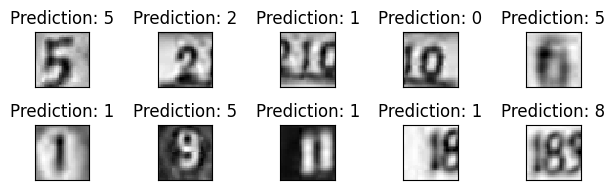

In [80]:
# Modellvorhersagen für die zuvor geladenen Beispielbilder berechnen
output = model(example_data)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# Zeige die ersten 10 Bilder und ihre Vorhersagen
for i in range(10):
    plt.subplot(5, 5, i+1)  # 5x5 Raster, aktueller Plot: i+1
    plt.tight_layout()      # Überlappungen vermeiden

    # Beispielbild anzeigen (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')

    # Vorhersage ermitteln:
    # max(1) → höchste Wahrscheinlichkeit entlang der Klassenachse
    # [1] → Index des Maximums → vorhergesagte Klasse
    predicted_label = output.data.max(1, keepdim=True)[1][i].item()

    # Titel mit der Vorhersage
    plt.title("Prediction: {}".format(predicted_label))

    # Achsen entfernen
    plt.xticks([])
    plt.yticks([])

# Plots anzeigen
plt.show()


## flexible CNN Struktur mit 5 Layern

In [81]:
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3, exp_info=""):
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(1, n_epochs + 1):

        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        # ===== Testen =====
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        prefix = f"[{exp_info}] " if exp_info else ""
        print(f"{prefix}Epoch {epoch} | Test Acc: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

    return model, train_losses, test_losses, test_accuracies


### Definition
Flexible SVHN CNN mit 1–5 Convolutional Layers

Dieser Code definiert eine **flexible Convolutional Neural Network (CNN) Architektur für das SVHN-Dataset**, die zwischen 1 und 5 Convolutional Layers variieren kann.
Die Architektur umfasst:
- Mehrere Convolutional Layers mit ReLU-Aktivierungen
- Max-Pooling nach bestimmten Convs
- Spatial Dropout nach der letzten Convolution
- Fully Connected Layers für die Klassifikation in 10 Klassen (Ziffern 0–9)
- Log-Softmax am Output für die Nutzung mit `NLLLoss`


In [82]:
class SVHNC5NN(nn.Module):
    def __init__(
        self,
        num_conv_layers=5,   # Anzahl der Convolutional Layers, flexibel 1–5
        dropout_rate=0.3,    # Dropout-Wahrscheinlichkeit nach Convs
        fc_hidden=50         # Anzahl der Neuronen im Fully Connected Hidden Layer
    ):
        super().__init__()

        # Sicherstellen, dass num_conv_layers im erlaubten Bereich liegt
        assert 1 <= num_conv_layers <= 5, "num_conv_layers muss zwischen 1 und 5 liegen"
        self.num_conv_layers = num_conv_layers

        # --- Convolutional Layers ---
        # Erstellen einer flexiblen Liste von Conv-Layern
        self.convs = nn.ModuleList()
        in_channels = 3  # RGB-Bilder haben 3 Kanäle
        out_channels_list = [10, 20, 30, 40, 50]  # Ausgabekanäle pro Layer
        kernel_sizes = [5, 5, 3, 3, 3]           # Kernelgrößen pro Layer

        for i in range(num_conv_layers):
            # Conv Layer erstellen und zur Liste hinzufügen
            self.convs.append(nn.Conv2d(in_channels, out_channels_list[i], kernel_size=kernel_sizes[i]))
            in_channels = out_channels_list[i]

        # Dropout Layer nach dem letzten Conv
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # --- Dummy Forward Pass ---
        # Berechnung der Flatten-Dimension automatisch
        dummy_input = torch.zeros(1, 3, 32, 32)  # 1 Dummy-Bild
        x = dummy_input
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            # MaxPooling nach Layer 2 und 4 (optional)
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)
        self.flatten_dim = x.numel()  # Anzahl der Features nach Flatten

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(self.flatten_dim, fc_hidden)  # Hidden Layer
        self.fc2 = nn.Linear(fc_hidden, 10)               # Output Layer: 10 Klassen (Ziffern)

    def forward(self, x):
        # --- Convolutional Forward Pass ---
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)  # Max-Pooling nach Layer 2 und 4

        # Dropout anwenden
        x = self.dropout(x)

        # Flatten für Fully Connected Layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Log-Softmax für NLLLoss
        return F.log_softmax(x, dim=1)


In [83]:
# wichtige Metriken speichern
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3, exp_info=""):
    """
    Führt Training + Testen über mehrere Epochen durch.
    Gibt zurück:
      - das trainierte Modell
      - train_loss pro Epoche
      - test_loss pro Epoche
      - train_accuracy pro Epoche
      - test_accuracy pro Epoche
    """
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        # ===== Training =====
        model.train()
        correct_train = 0
        train_loss_epoch = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct_train += pred.eq(target).sum().item()

        train_loss_epoch /= len(train_loader.dataset)
        train_acc_epoch = 100. * correct_train / len(train_loader.dataset)

        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # ===== Test =====
        model.eval()
        test_loss_epoch = 0
        correct_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss_epoch += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct_test += pred.eq(target).sum().item()

        test_loss_epoch /= len(test_loader.dataset)
        test_acc_epoch = 100. * correct_test / len(test_loader.dataset)

        test_losses.append(test_loss_epoch)
        test_accuracies.append(test_acc_epoch)

        # Ausgabe
        prefix = f"[{exp_info}] " if exp_info else ""
        print(f"{prefix}Epoch {epoch} | "
              f"Train Acc: {train_acc_epoch:.2f}% | Train Loss: {train_loss_epoch:.4f} | "
              f"Test Acc: {test_acc_epoch:.2f}% | Test Loss: {test_loss_epoch:.4f}")

    # Alles zurückgeben, inklusive trainiertem Modell
    return model, train_losses, test_losses, train_accuracies, test_accuracies


In [84]:
ALL_MODELS = {}      # speichert die trainierten Modelle
ALL_RESULTS = {}     # speichert Losses & Accuracies pro Modell
EPOCHS = 10
learning_rates = [0.2, 0.1, 0.01]
batch_sizes = [32, 64, 128, 256]


### 1 Layer

In [85]:
NUM_CONV_LAYERS = 1
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=1, LR=0.2, B=32 =====
[L1_LR0.2_B32] Epoch 1 | Train Acc: 18.85% | Train Loss: 2.2408 | Test Acc: 19.59% | Test Loss: 2.2271
[L1_LR0.2_B32] Epoch 2 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2272
[L1_LR0.2_B32] Epoch 3 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2297
[L1_LR0.2_B32] Epoch 4 | Train Acc: 18.88% | Train Loss: 2.2389 | Test Acc: 19.79% | Test Loss: 2.2186
[L1_LR0.2_B32] Epoch 5 | Train Acc: 20.43% | Train Loss: 2.2078 | Test Acc: 19.59% | Test Loss: 2.2265
[L1_LR0.2_B32] Epoch 6 | Train Acc: 18.91% | Train Loss: 2.2398 | Test Acc: 19.59% | Test Loss: 2.2271
[L1_LR0.2_B32] Epoch 7 | Train Acc: 18.91% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2275
[L1_LR0.2_B32] Epoch 8 | Train Acc: 18.87% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2238
[L1_LR0.2_B32] Epoch 9 | Train Acc: 18.90% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2258
[L1_LR0.2_B32] Epoch 10 | 

### 2 Layer

In [124]:
NUM_CONV_LAYERS = 2
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=2, LR=0.2, B=32 =====
[L2_LR0.2_B32] Epoch 1 | Train Acc: 18.88% | Train Loss: 2.2395 | Test Acc: 19.59% | Test Loss: 2.2279
[L2_LR0.2_B32] Epoch 2 | Train Acc: 18.87% | Train Loss: 2.2389 | Test Acc: 19.59% | Test Loss: 2.2248
[L2_LR0.2_B32] Epoch 3 | Train Acc: 18.93% | Train Loss: 2.2388 | Test Acc: 19.59% | Test Loss: 2.2262
[L2_LR0.2_B32] Epoch 4 | Train Acc: 18.86% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2294
[L2_LR0.2_B32] Epoch 5 | Train Acc: 18.88% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2277
[L2_LR0.2_B32] Epoch 6 | Train Acc: 18.88% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2239
[L2_LR0.2_B32] Epoch 7 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2256
[L2_LR0.2_B32] Epoch 8 | Train Acc: 18.89% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2247
[L2_LR0.2_B32] Epoch 9 | Train Acc: 18.99% | Train Loss: 2.2368 | Test Acc: 19.59% | Test Loss: 2.2267
[L2_LR0.2_B32] Epoch 10 | 

### 3 Layer

In [125]:
NUM_CONV_LAYERS = 3
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=3, LR=0.2, B=32 =====
[L3_LR0.2_B32] Epoch 1 | Train Acc: 21.64% | Train Loss: 2.1801 | Test Acc: 19.59% | Test Loss: 2.2267
[L3_LR0.2_B32] Epoch 2 | Train Acc: 18.85% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2288
[L3_LR0.2_B32] Epoch 3 | Train Acc: 18.90% | Train Loss: 2.2395 | Test Acc: 19.59% | Test Loss: 2.2282
[L3_LR0.2_B32] Epoch 4 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2265
[L3_LR0.2_B32] Epoch 5 | Train Acc: 18.88% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2254
[L3_LR0.2_B32] Epoch 6 | Train Acc: 18.91% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2290
[L3_LR0.2_B32] Epoch 7 | Train Acc: 18.88% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2248
[L3_LR0.2_B32] Epoch 8 | Train Acc: 18.88% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2289
[L3_LR0.2_B32] Epoch 9 | Train Acc: 18.89% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2272
[L3_LR0.2_B32] Epoch 10 | 

### 4 Layer

In [135]:
NUM_CONV_LAYERS = 4
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=4, LR=0.2, B=32 =====
[L4_LR0.2_B32] Epoch 1 | Train Acc: 19.02% | Train Loss: 2.2382 | Test Acc: 19.59% | Test Loss: 2.2234
[L4_LR0.2_B32] Epoch 2 | Train Acc: 18.90% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2264
[L4_LR0.2_B32] Epoch 3 | Train Acc: 18.89% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2262
[L4_LR0.2_B32] Epoch 4 | Train Acc: 18.86% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2254
[L4_LR0.2_B32] Epoch 5 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2320
[L4_LR0.2_B32] Epoch 6 | Train Acc: 18.90% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2264
[L4_LR0.2_B32] Epoch 7 | Train Acc: 18.90% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2250
[L4_LR0.2_B32] Epoch 8 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2271
[L4_LR0.2_B32] Epoch 9 | Train Acc: 18.87% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2283
[L4_LR0.2_B32] Epoch 10 | 

### 5 Layer

In [136]:
NUM_CONV_LAYERS = 5
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=5, LR=0.2, B=32 =====
[L5_LR0.2_B32] Epoch 1 | Train Acc: 18.85% | Train Loss: 2.2396 | Test Acc: 19.59% | Test Loss: 2.2276
[L5_LR0.2_B32] Epoch 2 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2257
[L5_LR0.2_B32] Epoch 3 | Train Acc: 18.85% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2274
[L5_LR0.2_B32] Epoch 4 | Train Acc: 18.91% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2250
[L5_LR0.2_B32] Epoch 5 | Train Acc: 18.92% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2270
[L5_LR0.2_B32] Epoch 6 | Train Acc: 18.87% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2282
[L5_LR0.2_B32] Epoch 7 | Train Acc: 18.87% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2330
[L5_LR0.2_B32] Epoch 8 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2305
[L5_LR0.2_B32] Epoch 9 | Train Acc: 18.90% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2245
[L5_LR0.2_B32] Epoch 10 | 

## Visualisierung

In diesem Abschnitt wollen wir die eben durchlaufenen Modelle miteinander vergleichen. Dafür schauen wir uns zunächst einmal alle Ergebnisse an.

Es wäre zweckmäßig, einen DataFrame zu erstellen, der die Anzahl der Layer, die Learning Rates, die Batch-Größen sowie die Ergebnisse der letzten Epoche jedes Experiments übersichtlich darstellt.

In [189]:
rows = []
for exp_name, res in ALL_RESULTS.items():
    rows.append({
        "layers": res["layers"],
        "learning_rate": res["lr"],
        "batch_size": res["batch"],
        "train_loss_last": res["train_loss"][-1],
        "train_acc_last": res["train_acc"][-1],
        "test_loss_last": res["test_loss"][-1],
        "test_acc_last": res["test_acc"][-1]
    })

Ergebnisliste = pd.DataFrame(rows)
Ergebnisliste

,layers,learning_rate,batch_size,train_loss_last,train_acc_last,test_loss_last,test_acc_last
0,1,0.20,32,2.239117,18.851441,2.229697,15.938076
1,1,0.20,64,1.327584,58.049060,1.223668,62.749693
2,1,0.20,128,1.315041,56.335913,1.278873,61.966042
3,1,0.20,256,1.058609,66.733554,1.196773,63.767671
4,1,0.10,32,1.195877,63.210342,1.146035,66.948371
5,1,0.10,64,0.875199,73.411415,1.018228,71.216195
6,1,0.10,128,0.585026,82.610536,0.719855,80.758297
7,1,0.10,256,0.562267,83.586551,0.685161,81.000307
8,1,0.01,32,0.638640,81.173130,0.699164,81.050246
9,1,0.01,64,0.626359,81.934832,0.682537,81.061770


im kommenden wollen wir alle Modelle nach deren Gleichheit gruppieren, um diese besser zu vergleichen

In [91]:
MODELS_BY_LAYER = {}
RESULTS_BY_LAYER = {}

MODELS_BY_LR = {}
RESULTS_BY_LR = {}

MODELS_BY_BATCH = {}
RESULTS_BY_BATCH = {}


In [92]:
for exp_name, result in ALL_RESULTS.items():

    layer = result["layers"]
    lr = result["lr"]
    bs = result["batch"]

    # ===== GROUP BY LAYER =====
    if layer not in MODELS_BY_LAYER:
        MODELS_BY_LAYER[layer] = {}
        RESULTS_BY_LAYER[layer] = {}

    MODELS_BY_LAYER[layer][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_LAYER[layer][exp_name] = result

    # ===== GROUP BY LEARNING RATE =====
    if lr not in MODELS_BY_LR:
        MODELS_BY_LR[lr] = {}
        RESULTS_BY_LR[lr] = {}

    MODELS_BY_LR[lr][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_LR[lr][exp_name] = result

    # ===== GROUP BY BATCH SIZE =====
    if bs not in MODELS_BY_BATCH:
        MODELS_BY_BATCH[bs] = {}
        RESULTS_BY_BATCH[bs] = {}

    MODELS_BY_BATCH[bs][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_BATCH[bs][exp_name] = result


um jetzt z.B. alle Ergebnisse aller Modelle mit 3 Layern zu bekommen führt man folgendes aus

In [187]:
RESULTS_BY_LAYER[3]

{'L1_LR0.2_B32': {'train_loss': [2.24077786222707,
   2.2391737782385785,
   2.2392658791596145,
   2.2388510738083123,
   2.2078089881529444,
   2.239778262830063,
   2.2391880529558263,
   2.239392694140808,
   2.2392124704330003,
   2.2391173624117875],
  'test_loss': [2.227105911186889,
   2.2272031273516544,
   2.2297418321212086,
   2.2185920567034794,
   2.2264620268645285,
   2.2271239339902347,
   2.2274879055222487,
   2.223832911483774,
   2.2257796022594523,
   2.229697074198474],
  'train_acc': [18.852805875206464,
   18.870551619640445,
   18.895122650395184,
   18.884202192281965,
   20.425351843509834,
   18.91013828030086,
   18.91013828030086,
   18.870551619640445,
   18.900582879451793,
   18.85144081794231],
  'test_acc': [19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.78718500307314,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   15.938076213890596],
  'layers': 1,
  'l

Nun wollen wir Vorbereitungen für die ersten Plots treffen.

In [159]:
def plot_accuracy(RESULTS, layers=None, lrs=None, batches=None, mode="test", title=None):
    # Filterfunktion
    def match(res):
        if layers is not None and not isinstance(layers, (list, tuple)):
            layers_list = [layers]
        else:
            layers_list = layers
        if layers_list is not None and res["layers"] not in layers_list:
            return False
        if lrs is not None and res["lr"] not in lrs:
            return False
        if batches is not None and res["batch"] not in batches:
            return False
        return True

    # passende Modelle filtern
    selected = {name: res for name, res in RESULTS.items() if match(res)}
    if len(selected) == 0:
        print("⚠️ Keine Modelle entsprechen diesem Filter.")
        return

    plt.figure(figsize=(10,6))

    # Plot
    for name, res in selected.items():
        if mode == "train":
            y = [v/100 for v in res["train_acc"]]  # Umrechnung in [0,1]
            plt.plot(y, marker='o', linestyle='-', label=f"{name} (train)")

        elif mode == "test":
            y = [v/100 for v in res["test_acc"]]
            plt.plot(y, marker='x', linestyle='--', label=f"{name} (test)")

        elif mode == "both":
            y_train = [v/100 for v in res["train_acc"]]
            y_test  = [v/100 for v in res["test_acc"]]
            plt.plot(y_train, marker='o', linestyle='-', label=f"{name} (train)")
            plt.plot(y_test, marker='x', linestyle='--', label=f"{name} (test)")

        else:
            raise ValueError("mode muss 'train', 'test' oder 'both' sein")

    plt.xlabel("Epoche")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.title(title or "Accuracy über Epochen")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Plots der Test-Accuracies der verschiedenen Layer

#### 1 Layer

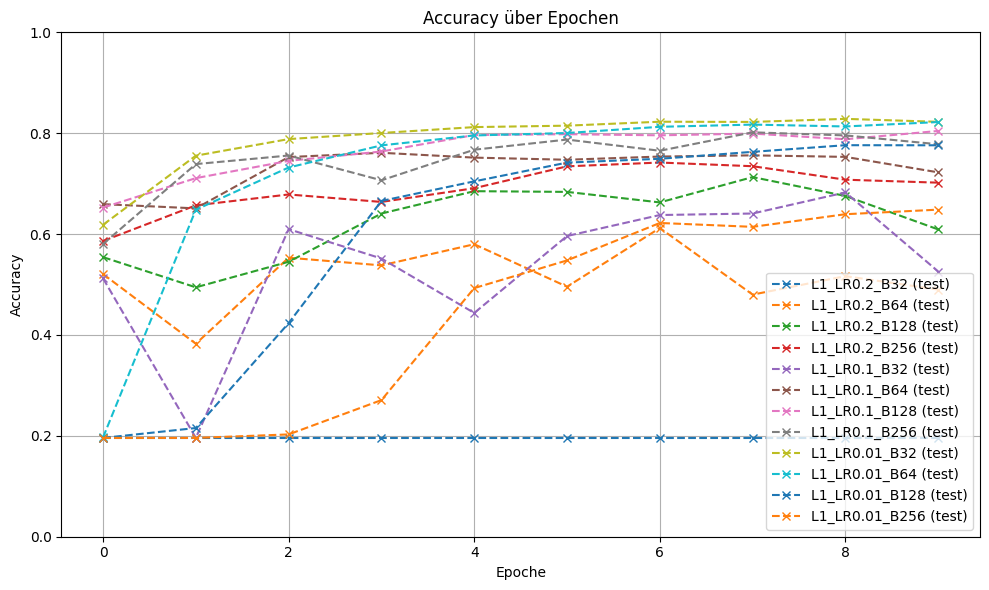

In [163]:
plot_accuracy(ALL_RESULTS, layers=[1], mode="test")   # nur Test Accuracy

#### 2 Layers

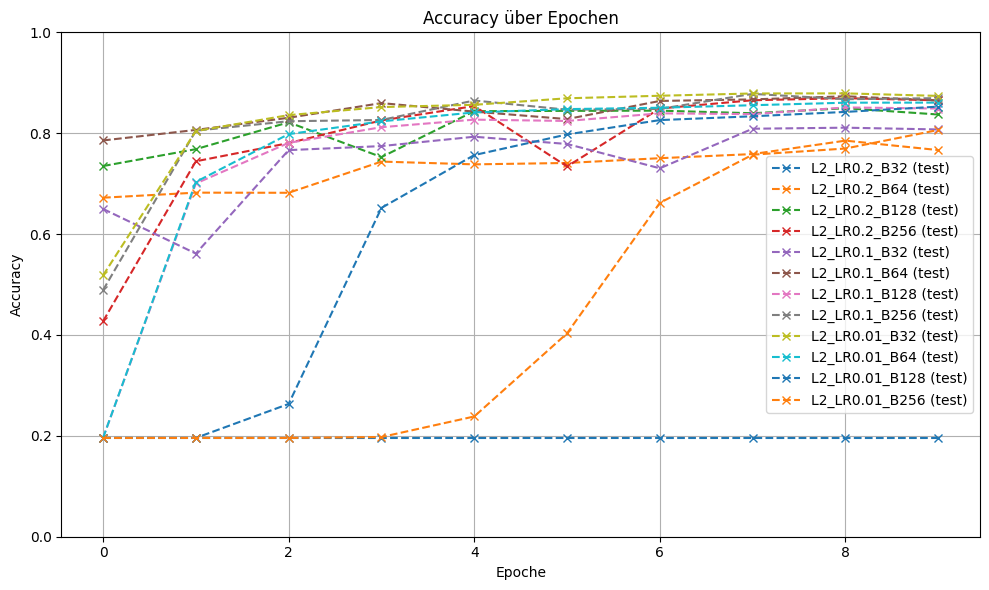

In [167]:
plot_accuracy(ALL_RESULTS, layers=[2], mode="test")   # nur Test Accuracy

#### 3 Layers

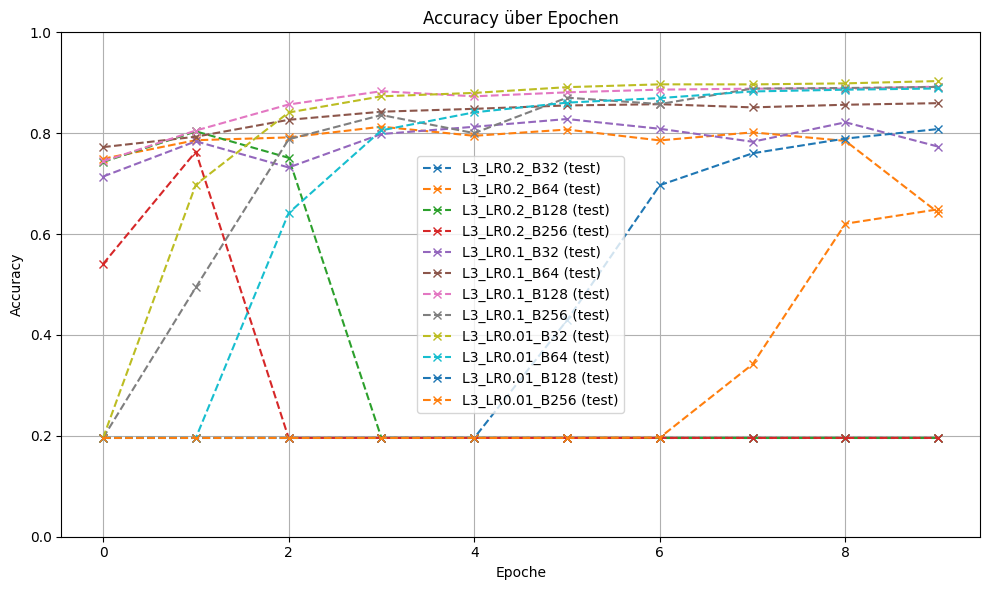

In [166]:
plot_accuracy(ALL_RESULTS, layers=[3], mode="test")   # nur Test Accuracy

#### 4 Layers

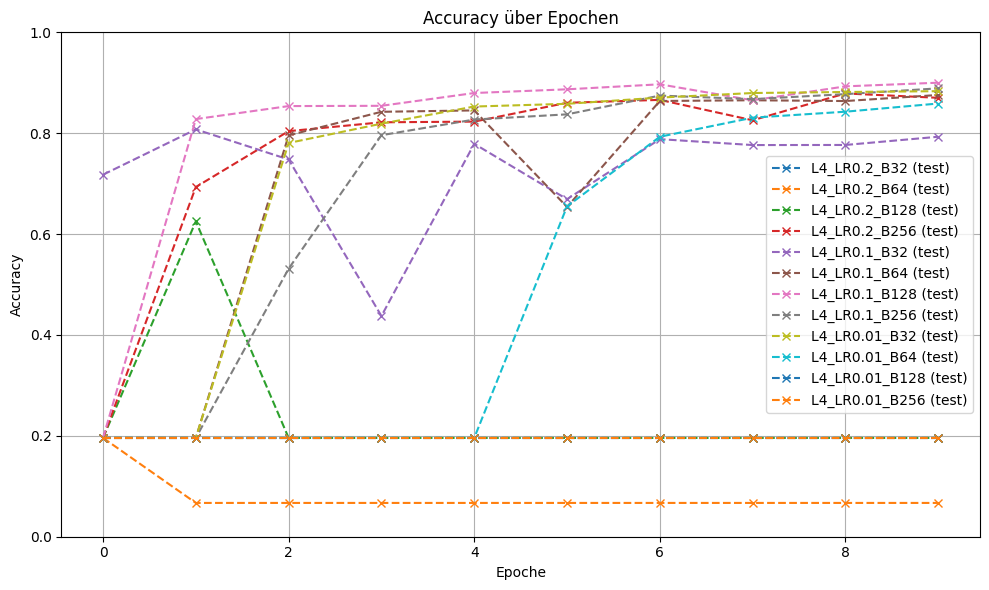

In [165]:
plot_accuracy(ALL_RESULTS, layers=[4], mode="test")   # nur Test Accuracy

#### 5 Layers

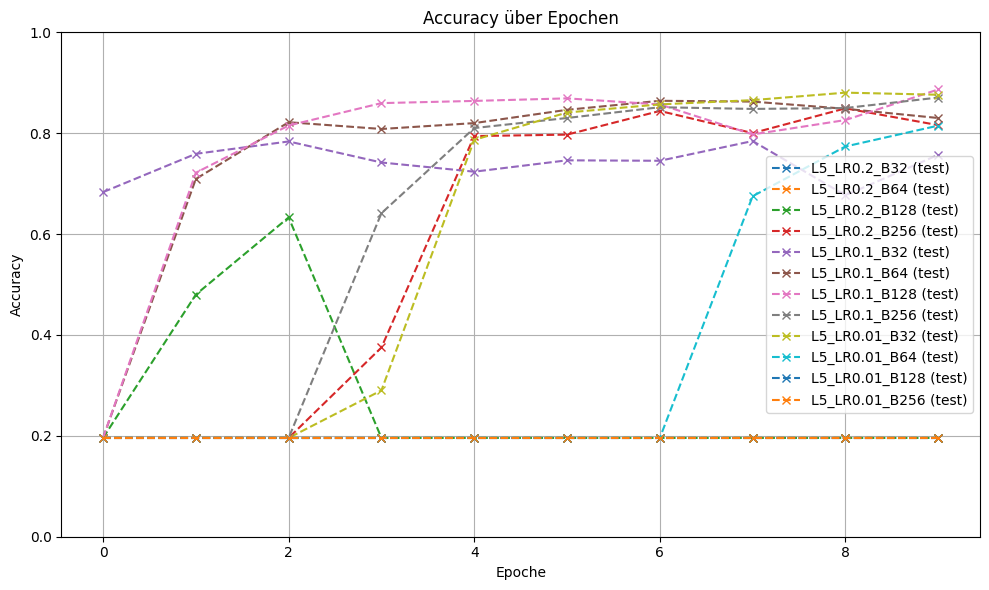

In [164]:
plot_accuracy(ALL_RESULTS, layers=[5], mode="test")   # nur Test Accuracy

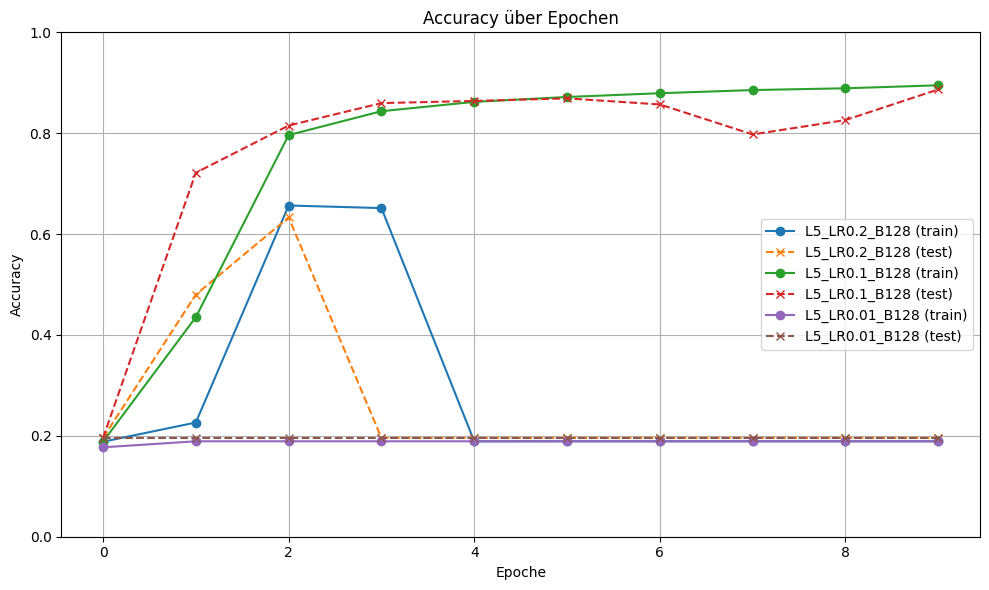

In [176]:
# Beschränkung auf genau 128 Batches
plot_accuracy(ALL_RESULTS, layers=5, batches=[128], mode="both")


#### Ersten Schlussfolgerungen

Am vielversprechendsten sind auf dem ersten Blick die Modelle mit 128 Batches und einer learning rate von 0.1.

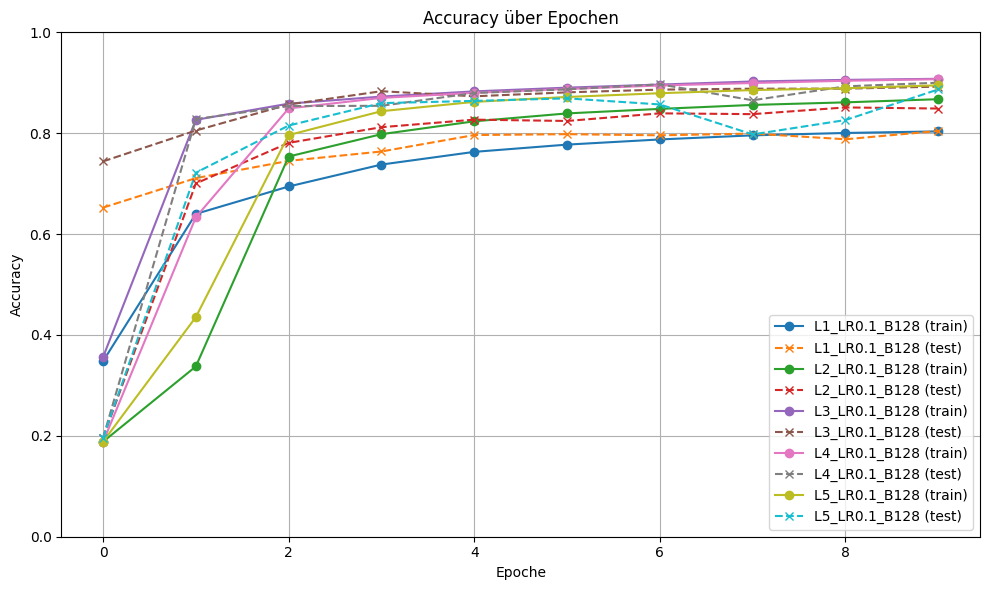

In [178]:
plot_accuracy(ALL_RESULTS, batches=[128], lrs =[0.1],mode="both")

Ganz im Gegenteil dazu mal 256 Batches und eine learning rate von 0.01. Dort werden gute Ergebnisse erst ab späterer Epochenzahl. Und 5 Layer können damit gar nicht trainiert werden.

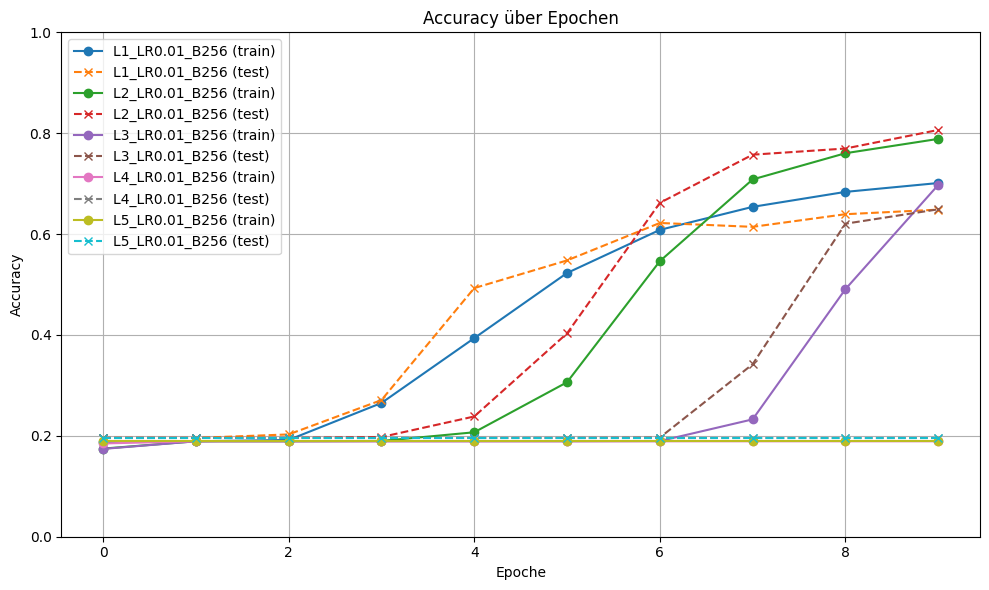

In [179]:
plot_accuracy(ALL_RESULTS, batches=[256], lrs =[0.01],mode="both")

Der andere Extremfall ist mit geringster Batchanzahl und höchster learning rate.

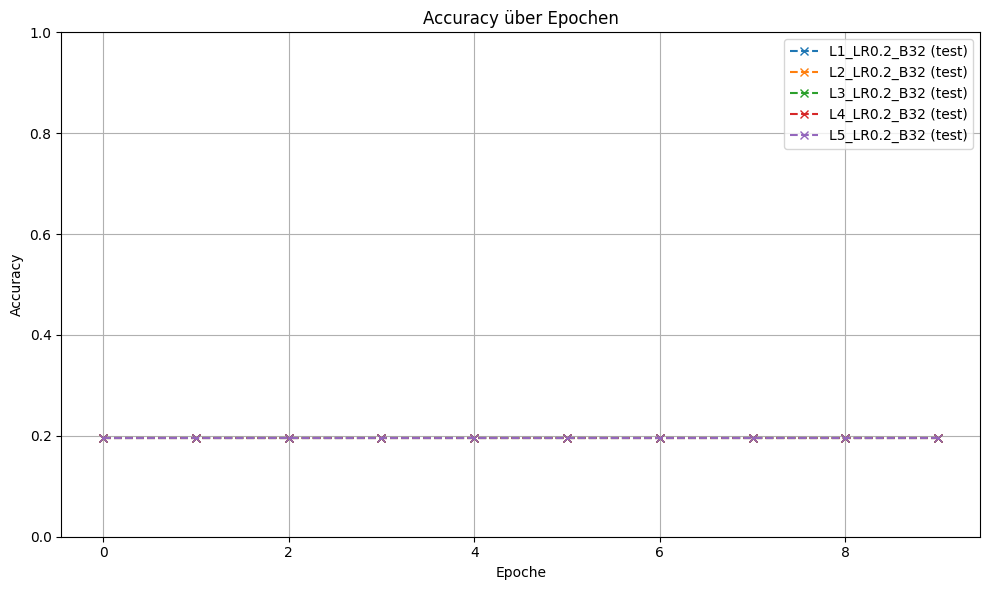

In [185]:
plot_accuracy(ALL_RESULTS, batches=[32], lrs = [0.2], mode="test")

dagegen passen geringe batches und geringe learning rate ganz gut zusammen, sowie hohe batch zahl mit hoher learning rate (außer bei drei Layern).

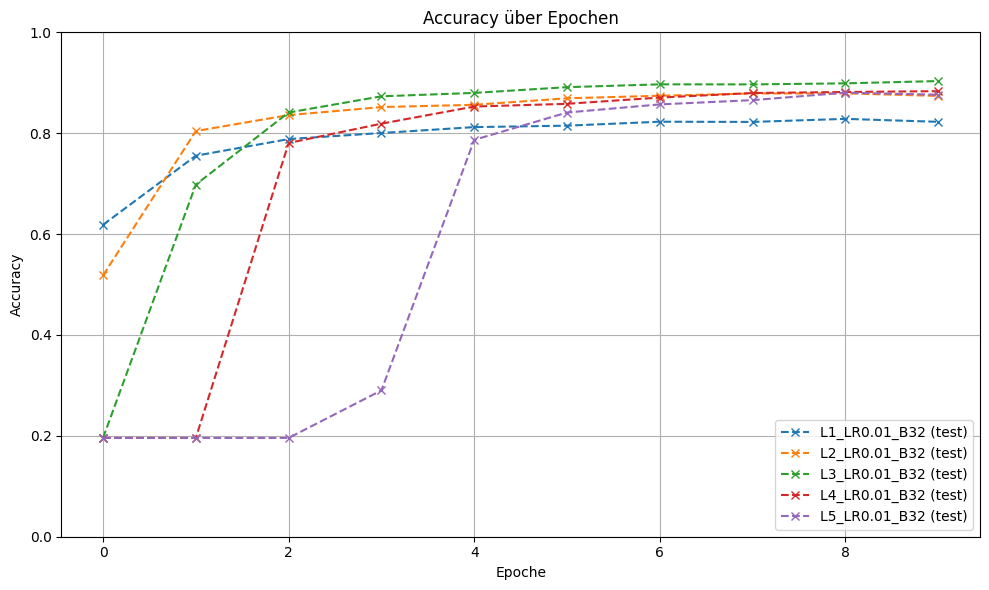

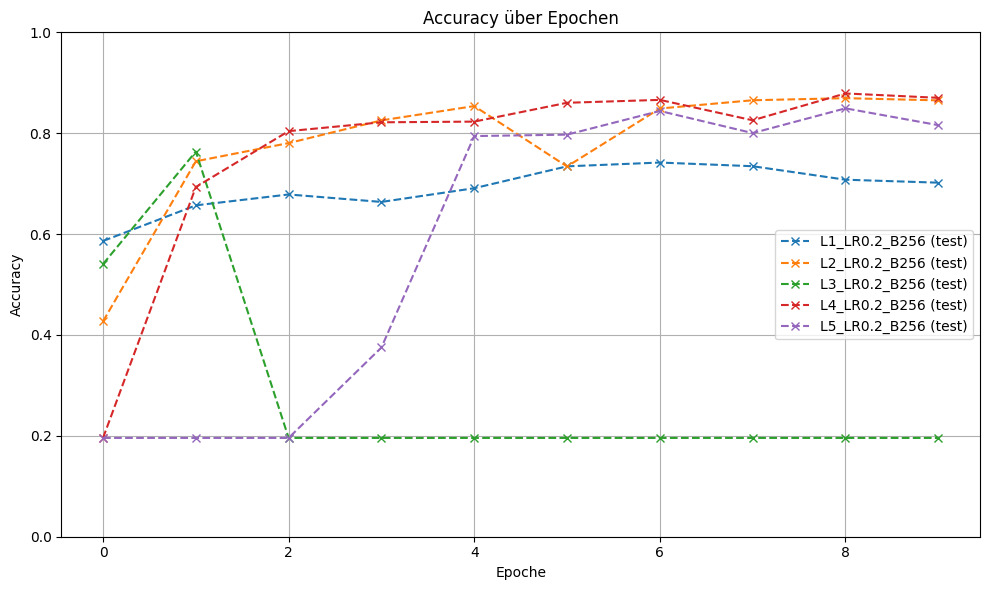

In [189]:
plot_accuracy(ALL_RESULTS, batches=[32], lrs = [0.01], mode="test")
plot_accuracy(ALL_RESULTS, batches=[256], lrs = [0.2], mode="test")

## Leistung via Zeit

#### Achtung !!! Die Zeitmessung kann viel Zeit in Anspruch nehmen.

Jetzt wollen wir noch schauen, ob sich eine geringfügig bessere Genauigkeit überhaupt lohnt im Verhältnis zur Traningszeit.

In [203]:
for lr in learning_rates:
    for bs in batch_sizes:

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        start_time = time.time()    # <-- Startzeit festhalten

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        elapsed = time.time() - start_time  # <-- Zeitdifferenz festhalten

        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs,
            "training_time_sec": elapsed
        }
        # Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model

[L1_LR0.2_B32] Epoch 1 | Train Acc: 18.88% | Train Loss: 2.2397 | Test Acc: 19.59% | Test Loss: 2.2289
[L1_LR0.2_B32] Epoch 2 | Train Acc: 21.11% | Train Loss: 2.1980 | Test Acc: 19.60% | Test Loss: 2.2265


KeyboardInterrupt: 

#### Trainingsdauer vs. Accuracy

In [184]:
def summarize_layer_performance(ALL_RESULTS, layers=[1,2,3,4,5], learning_rates=[0.01,0.1,0.2], batch_sizes=[32,64,128,256]):
    summary = []
    # Error Meldung vermeiden
    for layer in layers:
        best_acc = 0.0
        total_time = 0.0
        found_model = False   # Falls Modell nicht ausgeführt, einfach 0 ausgeben

        for lr in learning_rates:
            for bs in batch_sizes:
                exp_name = f"L{layer}_LR{lr}_B{bs}"
                if exp_name in ALL_RESULTS:
                    found_model = True     # Falls Modell ausgeführt, echte Werte in Tabelle eintragen
                    acc = max(ALL_RESULTS[exp_name]["test_acc"])  # maximale Testgenauigkeit
                    best_acc = max(best_acc, acc)
                    elapsed = ALL_RESULTS[exp_name].get("training_time_sec", 0.0)
                    total_time += elapsed

        if not found_model:
            best_acc = 0.0
            total_time = 0.0

        summary.append({
            "Layer": layer,
            "Best Test Accuracy (%)": best_acc,  # angabe in Prozent
            "Total Training Time (sec)": total_time  # Daten aus der Zeitmessung
        })

    tabelle_summary = pd.DataFrame(summary)
    return tabelle_summary

# Tabelle anzeigen
Tabelle_Laufzeit = summarize_layer_performance(ALL_RESULTS)
print(Tabelle_Laufzeit)


   Layer  Best Test Accuracy (%)  Total Training Time (sec)
0      1               81.522741                        0.0
1      2                0.000000                        0.0
2      3                0.000000                        0.0
3      4                0.000000                        0.0
4      5                0.000000                        0.0


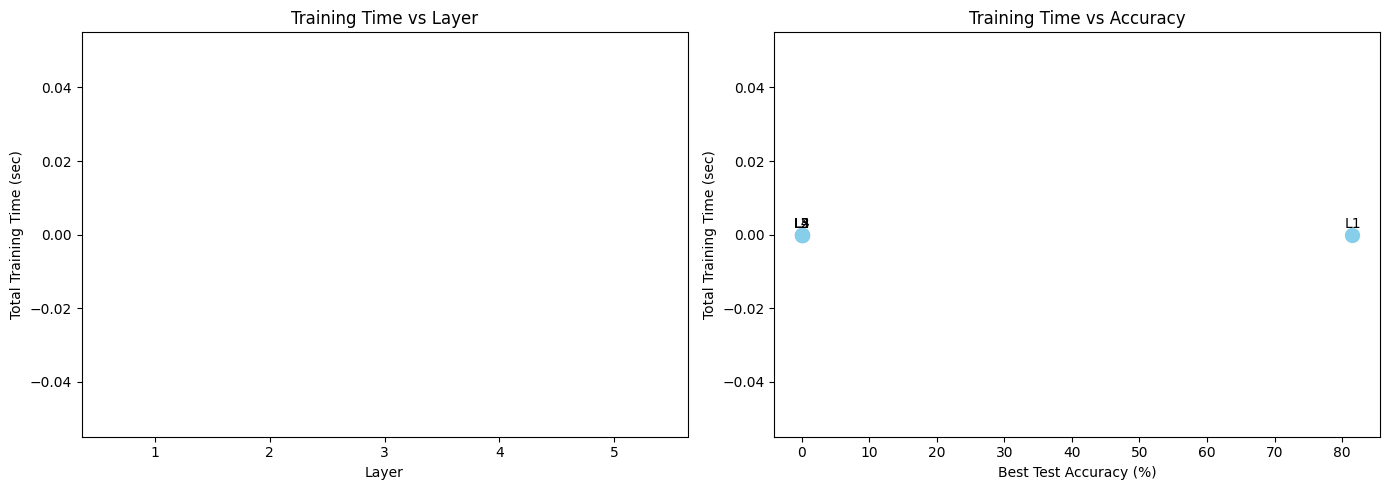

In [188]:

# Plot zur Tabelle erstellen
def plot_layer_performance(summary_table):
    """
    Zeigt zwei Plots nebeneinander:
    1. Trainingszeit pro Layer
    2. Trainingszeit vs Test Accuracy pro Layer
    """

    layers = summary_table['Layer']
    accuracy = summary_table['Best Test Accuracy (%)']
    times = summary_table['Total Training Time (sec)']

    x = np.arange(len(layers))

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # -------------------------------
    # Plot 1: Training Time vs Layer
    # -------------------------------
    axes[0].bar(x, times, color='salmon')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(layers)
    axes[0].set_xlabel('Layer')
    axes[0].set_ylabel('Total Training Time (sec)')
    axes[0].set_title('Training Time vs Layer')

    # -------------------------------
    # Plot 2: Training Time vs Accuracy
    # -------------------------------
    axes[1].scatter(accuracy, times, color='skyblue', s=100)
    for i, layer in enumerate(layers):
        axes[1].annotate(f"L{layer}", (accuracy[i], times[i]), textcoords="offset points", xytext=(0,5), ha='center')
    axes[1].set_xlabel('Best Test Accuracy (%)')
    axes[1].set_ylabel('Total Training Time (sec)')
    axes[1].set_title('Training Time vs Accuracy')

    plt.tight_layout()
    plt.show()

# Anwenden auf Tabelle_Laufzeit
plot_layer_performance(Tabelle_Laufzeit)

Wir können hier einmal sehen wir stark die Trainingszeit von mehr Layers beeinträchtigt wird. Im Vergleich dazu sehen wir wie sich eine steigende Trainingszeit (und damit verbunden tiefere Modelle) die Genauigkeit eines Modells beeinflussen können.

### Ausgewählte Modelle vergleichen

Wir betrachten also folglich nur noch die Modelle mit einer learning rate von 0.1 und einer batch zahl von 128.

#### Confusion Matrix

In [125]:
def compute_predictions_for_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x)
            preds = logits.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred


In [126]:
# Generiere Vorhersagen über alle Modelle auf dem Testset
for name, model in ALL_MODELS.items():

    print(f"Generiere Predictions für {name} ...")

    y_true, y_pred = compute_predictions_for_model(model, test_loader)

    ALL_RESULTS[name]["y_true"] = y_true
    ALL_RESULTS[name]["y_pred"] = y_pred

print("\nAlle Modelle haben jetzt y_true und y_pred gespeichert!")


📥 Generiere Predictions für L1_LR0.2_B32 ...
📥 Generiere Predictions für L1_LR0.2_B64 ...
📥 Generiere Predictions für L1_LR0.2_B128 ...
📥 Generiere Predictions für L1_LR0.2_B256 ...
📥 Generiere Predictions für L1_LR0.1_B32 ...
📥 Generiere Predictions für L1_LR0.1_B64 ...
📥 Generiere Predictions für L1_LR0.1_B128 ...
📥 Generiere Predictions für L1_LR0.1_B256 ...
📥 Generiere Predictions für L1_LR0.01_B32 ...
📥 Generiere Predictions für L1_LR0.01_B64 ...
📥 Generiere Predictions für L1_LR0.01_B128 ...
📥 Generiere Predictions für L1_LR0.01_B256 ...

✅ Alle Modelle haben jetzt y_true und y_pred gespeichert!


In [197]:
# Matrizenstruktur festlegen
def plot_confusion_for(name):
    res = ALL_RESULTS[name]
    y_true = res["y_true"]
    y_pred = res["y_pred"]

    cm = confusion_matrix(y_true, y_pred)  # Vergleich Vorhersage mit echten wahrer Ziffer

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Schauen wir wie die Confusion Matrix für die verschiedenen Layer bei konstanter LR und Batches sich verändert.

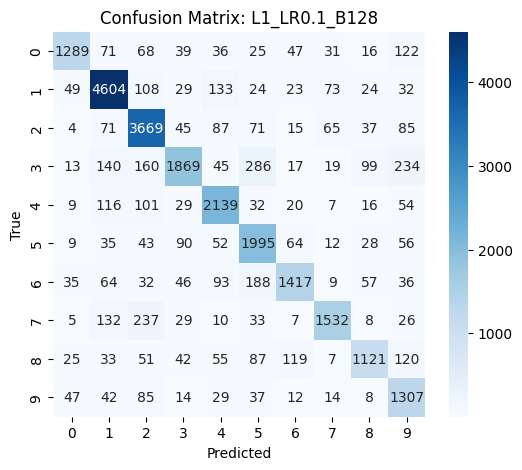

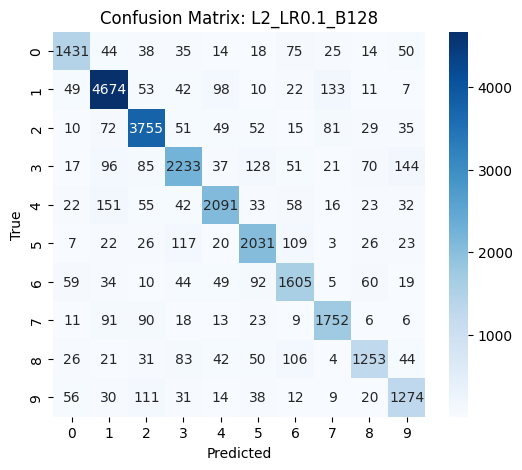

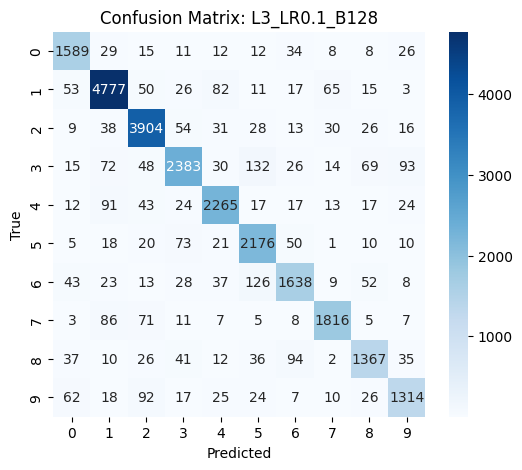

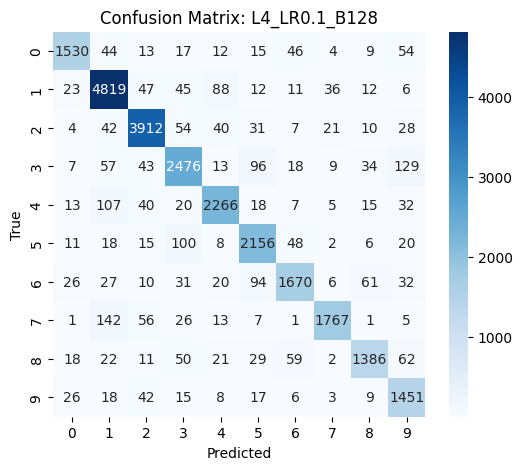

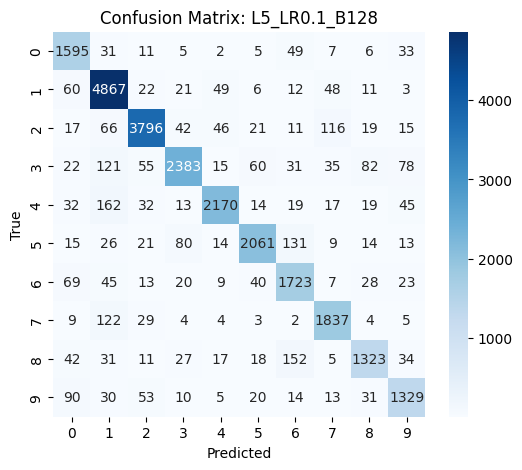

In [198]:
for name, res in ALL_RESULTS.items():
    if res["lr"] == 0.1 and res["batch"] == 128:
        plot_confusion_for(name)


#### Metriken

In [127]:
def metrics_for_models(ALL_RESULTS, lr=None, batch=None):
    """
    Gibt Precision / Recall / F1-Scores für alle Modelle mit bestimmter
    Learning Rate und Batch Size aus.
    """

    for name, res in ALL_RESULTS.items():

        # Filter anwenden
        if lr is not None and res["lr"] != lr:
            continue
        if batch is not None and res["batch"] != batch:
            continue

        # Predictions prüfen
        if "y_true" not in res or "y_pred" not in res:
            print(f"⚠️ {name} hat keine gespeicherten y_true/y_pred — übersprungen.")
            continue

        y_true = res["y_true"]
        y_pred = res["y_pred"]

        print(f"\n==============================")
        print(f"📊 METRIKEN FÜR MODELL: {name}")
        print(f"==============================")

        print(classification_report(
            y_true, y_pred,
            digits=4  # schönere Formatierung
        ))


In [200]:
metrics_for_models(ALL_RESULTS, lr=0.1, batch=128)


📊 METRIKEN FÜR MODELL: L1_LR0.1_B128
              precision    recall  f1-score   support

           0     0.8680    0.7391    0.7984      1744
           1     0.8674    0.9029    0.8848      5099
           2     0.8057    0.8843    0.8432      4149
           3     0.8374    0.6485    0.7309      2882
           4     0.7984    0.8478    0.8224      2523
           5     0.7181    0.8368    0.7730      2384
           6     0.8139    0.7167    0.7622      1977
           7     0.8660    0.7588    0.8089      2019
           8     0.7928    0.6753    0.7293      1660
           9     0.6308    0.8194    0.7128      1595

    accuracy                         0.8045     26032
   macro avg     0.7998    0.7830    0.7866     26032
weighted avg     0.8105    0.8045    0.8034     26032


📊 METRIKEN FÜR MODELL: L2_LR0.1_B128
              precision    recall  f1-score   support

           0     0.8477    0.8205    0.8339      1744
           1     0.8928    0.9167    0.9046      5099
  

## Output Daten: Vergleich zwischen Vorhersagen und wahren Werten

#### In diesem Abschnitt wollen wir Originalbilder aus dem Dataset anzeigen und sehen was das CNN für die jeweilligen layer vorhergesagt hat.

Beginnen wir mit ungefilterten Vorhersagen

In [190]:
def plot_predictions_across_hyperparams(layer, num_images=4, images_per_row=2,
                                        learning_rates=[0.01,0.1,0.2],
                                        batch_sizes=[32,64,128,256],
                                        seed=None):
    """
    Zeigt num_images zufällige Testbilder in einem Raster, darunter die Predictions
    für alle Kombinationen von Learning Rate (LR) und Batch Size des angegebenen Layers.
    seed: optional, fixiert die Zufallsauswahl der Bilder für Reproduzierbarkeit.
    """

    # Zugriff auf alle Modelle für den gewählten Layer
    models_layer = MODELS_BY_LAYER[layer]

    # Seed setzen, für die Vergleichbarkeit
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # Zufällige Bildindices aus dem Testset auswählen und extrahieren
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])

    n_rows = math.ceil(num_images / images_per_row)
    n_cols = min(images_per_row, num_images)

    # Subplots bauen
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    # Wenn nur eine Spalte, axes zu 2D-Liste umwandeln für konsistente Indizierung
    if n_cols == 1:
        axes = [[ax] for ax in axes]

    # Schleife für die ausgewählten Bilder
    for idx, (img, label) in enumerate(zip(images, labels)):
        # Raster
        row = idx // images_per_row
        col = idx % images_per_row
        ax = axes[row][col]
        # Kanäle ordnen
        ax.imshow(img.permute(1,2,0))
        ax.axis("off")  # Achsen ausblenden

        # Predictions sammeln über alle LR x Batches
        pred_texts = []
        for lr in learning_rates:
            for bs in batch_sizes:
                exp_name = f"L{layer}_LR{lr}_B{bs}"
                model = models_layer[exp_name]
                model.eval()
                with torch.no_grad():
                    output = model(img.unsqueeze(0))  # Bild in Batch-Form bringen
                    pred = output.argmax(dim=1).item()  # Vorhersage extrahieren
                pred_texts.append(f"LR{lr} B{bs}: {pred}")

        # Text zu jedem Bild erstellen: Ground Truth + Vorhersagen
        text = f"GT: {label}\n" + "\n".join([", ".join(pred_texts[i*len(batch_sizes):(i+1)*len(batch_sizes)])
                                             for i in range(len(learning_rates))])
        ax.set_title(text, fontsize=9)  # Schrift anpassen

    # Layout optimieren
    plt.tight_layout()
    plt.show()

Zu sehen sind erstmal 4 Bilder mit allen Vorhersagen (je Batch x Learning Rate) zu einem Layer. Im weiteren werden nwir noch intialisieren, dass wir ganz frei wählen können, welchen spezifischen Fall wir angezigt haben möchten. Dazu gibt es dann immer 5 Bilder Vorhersage + realer Ziffer.

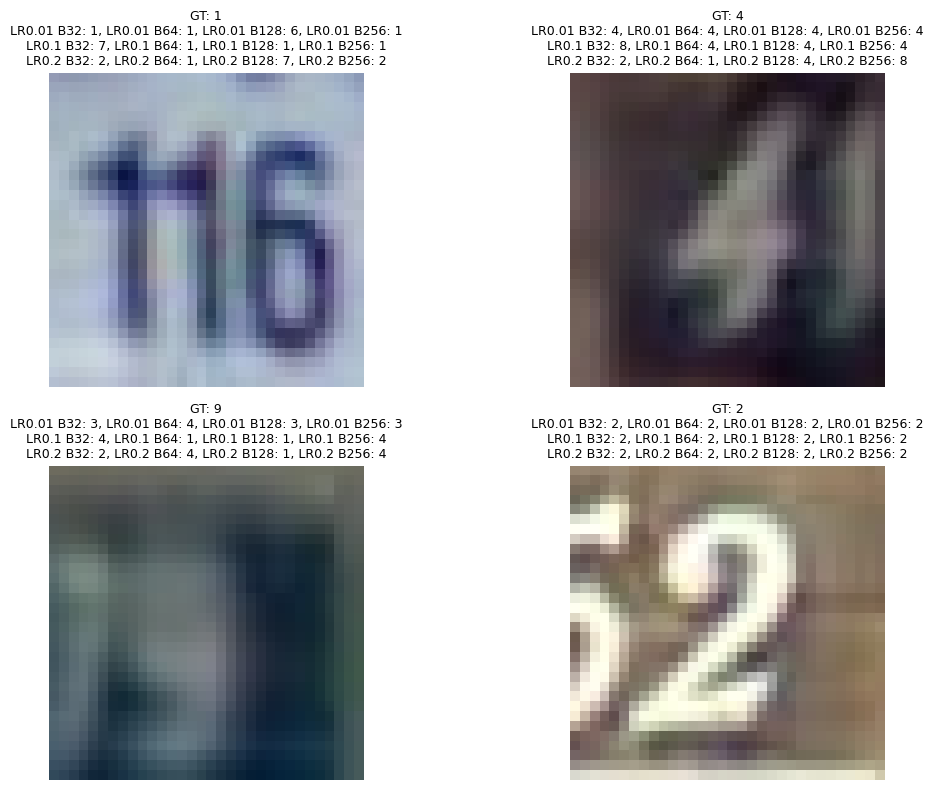

In [191]:
# Aufruf für Layer 1
plot_predictions_across_hyperparams(layer=1, num_images=4, seed=123)

In [ ]:
# Aufruf für Layer 2
plot_predictions_across_hyperparams(layer=2, num_images=4, seed=123)

In [ ]:
# Afruf für Layer 3
plot_predictions_across_hyperparams(layer=1, num_images=4, seed=123)

In [ ]:
# Aufruf für Layer 4
plot_predictions_across_hyperparams(layer=4, num_images=4, seed=123)

In [ ]:
# Aufruf für Layer 5
plot_predictions_across_hyperparams(layer=5, num_images=4, seed=123)

Komplett frei wählbar! Beachte: LR = [0.01, 0.1, 0.2]; B = [32, 64, 128, 256]; Layer = (1, 2, 3, 4, 5)

In [192]:
def plot_predictions_single_model(layer, lr, batch, num_images=5, seed=None):
    """
    Zeigt num_images zufällige Testbilder nebeneinander.
    Über jedem Bild:
      - echte Zahl
      - Vorhersage des Modells mit gewähltem Layer, LR und Batch
    seed: optional, für reproduzierbare Zufallsauswahl
    """
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # Modell für die gewählten Hyperparameter auswählen
    exp_name = f"L{layer}_LR{lr}_B{batch}"
    model = ALL_MODELS[exp_name]
    model.eval()

    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])

    fig, axes = plt.subplots(1, num_images, figsize=(3*num_images, 4))
    if num_images == 1:
        axes = [axes]

    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i]
        ax.imshow(img.permute(1,2,0))
        ax.axis("off")

        with torch.no_grad():
            output = model(img.unsqueeze(0))
            pred = output.argmax(dim=1).item()

        ax.set_title(f"GT: {label}\nPred: {pred}", fontsize=10)

    plt.tight_layout()
    plt.show()


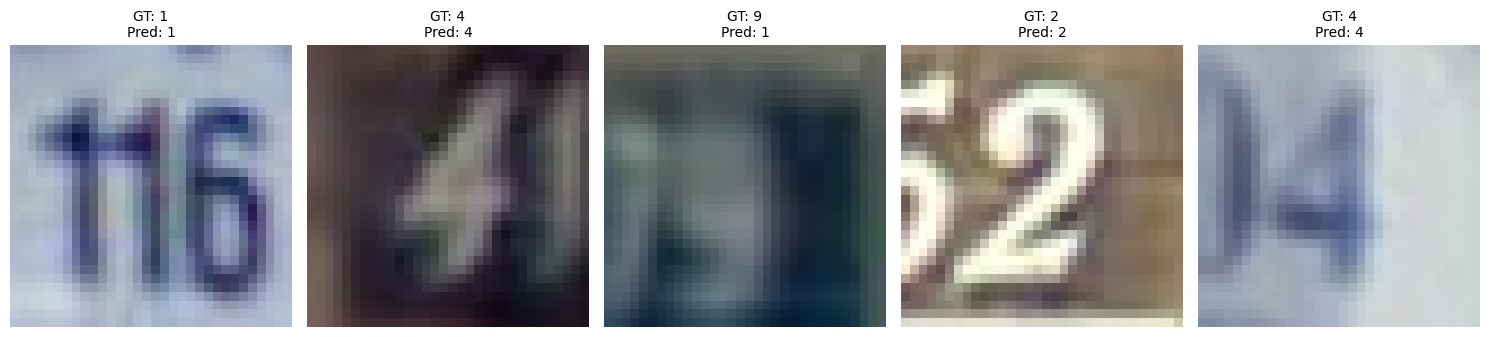

In [193]:
plot_predictions_single_model(layer=1, lr=0.1, batch=128, num_images=5, seed=123)

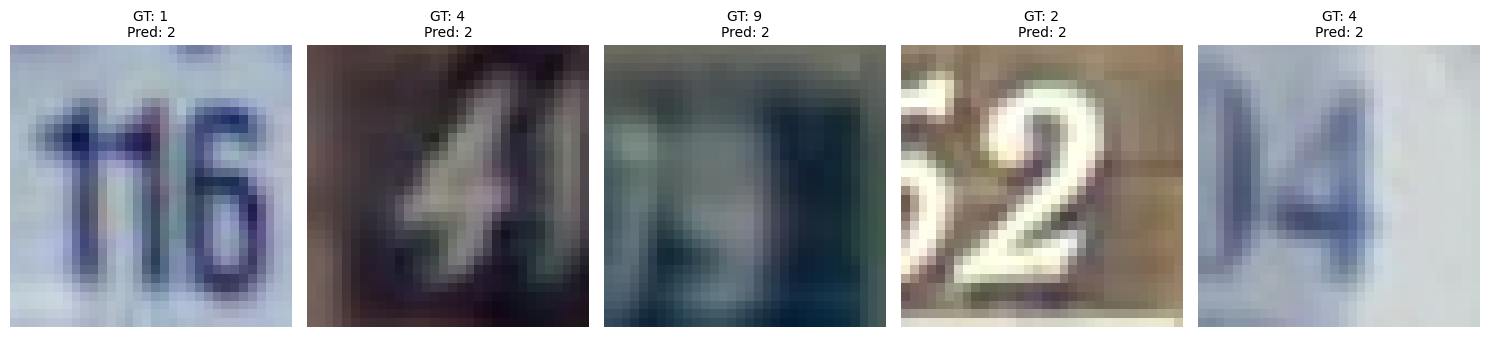

In [194]:
plot_predictions_single_model(layer=1, lr=0.2, batch=32, num_images=5, seed=123)

In [ ]:
plot_predictions_single_model(layer=3, lr=0.1, batch=64, num_images=5, seed=123)

### Es wird Zeit die Vorhersagen zu filtern, betrachten wir also ausschließlich Fehlklassifikationen

In [195]:
def plot_misclassified_across_hyperparams(layer, lr, batch, num_images=5, images_per_row=5, seed=None):
    """
    Zeigt eine Auswahl von Fehlklassifikationen für ein bestimmtes Modell,
    definiert durch Layer, Learning Rate und Batch Size.

    Über jedem Bild werden angezeigt:
      - GT (Ground Truth / echte Zahl)
      - Prediction des gewählten Modells
    """

    # Seed setzen, für Vergleichbarkeit
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # Outputs anhand Layer, LR und Batch laden
    exp_name = f"L{layer}_LR{lr}_B{batch}"
    model = MODELS_BY_LAYER[layer][exp_name]
    model.eval()

    # Unter den geladenen Ergebnissen, nur die falsch vorhergesagten wählen
    y_true = ALL_RESULTS[exp_name]["y_true"]
    y_pred = ALL_RESULTS[exp_name]["y_pred"]
    misclassified_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

    # Wenn keine Fehlklassifikationen gefunden werden, Abbruch
    if len(misclassified_indices) == 0:
        print("Keine Fehlklassifikationen gefunden!")
        return

    # Zufällige Auswahl von Fehlklassifikationen
    selected_indices = random.sample(misclassified_indices, min(num_images, len(misclassified_indices)))

    # Bilder, Labels und Predictions vorbereiten
    images = [test_dataset[i][0] for i in selected_indices]    # Bilddaten
    labels = [test_dataset[i][1] for i in selected_indices]    # Ground Truth
    predictions = [y_pred[i] for i in selected_indices]        # Modellvorhersagen

    # Subplots
    n_cols = min(images_per_row, len(images))
    n_rows = math.ceil(len(images) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 4*n_rows))

    # Sicherstellen, dass axes immer als verschachtelte Liste vorliegen
    if n_rows == 1:
        axes = [axes]
    if n_cols == 1:
        axes = [[ax] for ax in axes]

    for idx, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row_idx][col_idx]

        # Bild anzeigen (RGB Channels an letzte Stelle)
        ax.imshow(img.permute(1,2,0))
        ax.axis("off")  # Achsen ausblenden

        #Ground Truth + Prediction anzeigen
        ax.set_title(f"GT: {label}\nPred: {pred}", fontsize=10)

    # Plot anzeigen
    plt.tight_layout()
    plt.show()

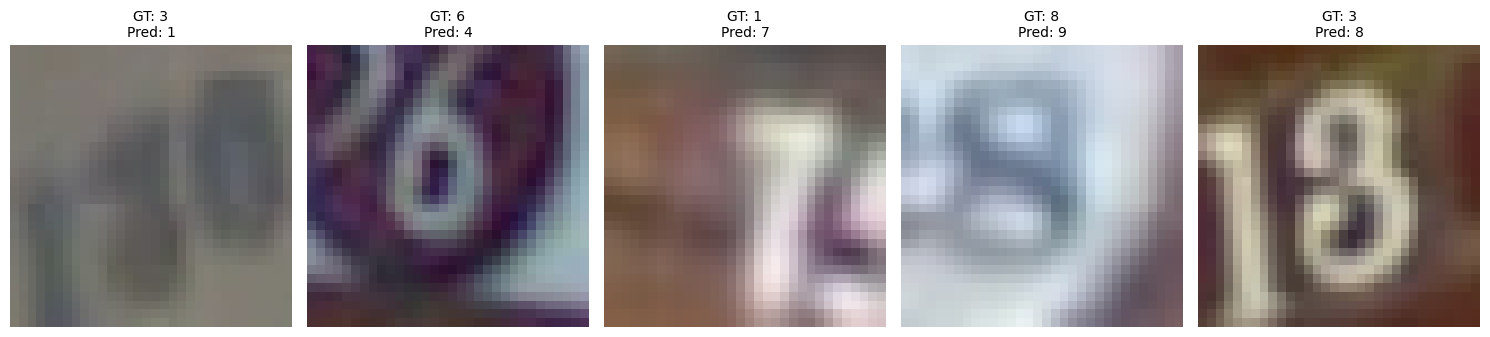

In [196]:
# Aufruf für Layer 1
plot_misclassified_across_hyperparams(layer=1, lr=0.1, batch=128, num_images=5, images_per_row=5, seed=123)

In [ ]:
# Aufruf für Layer 2
plot_misclassified_across_hyperparams(layer=2, lr=0.01, batch=256, num_images=5, images_per_row=5, seed=123)

In [ ]:
# Aufruf für Layer 3
plot_misclassified_across_hyperparams(layer=3, lr=0.2, batch=256, num_images=5, images_per_row=5, seed=123)

In [ ]:
# Aufruf für Layer 4
plot_misclassified_across_hyperparams(layer=4, lr=0.1, batch=128, num_images=5, images_per_row=5, seed=123)

In [ ]:
# Aufruf für Layer 5
plot_misclassified_across_hyperparams(layer=5, lr=0.1, batch=128, num_images=5, images_per_row=5, seed=123)

Wir erkennen also, dass Bilder oft signifikant schlechtere Qualitäten aufweisen, wenn das CNN eine falsche Vorhersage trifft.

Als nächstes wollen wir die falsch vorhergesagten Ziffern mithilfe zweier Diagramme ausbauen.

In [148]:
# Dictionary, um die "häufigste falsch vorhergesagte Ziffer" pro Layer zu speichern
most_misclassified_digit = {}

for layer in [1, 2, 3, 4, 5]:  # <-- hier beliebige Layer eintragen, egal ob nur einer oder ob mehrere
    name = f"L{layer}_LR0.1_B128"
    res = ALL_RESULTS[name]
    y_true = res["y_true"]
    y_pred = res["y_pred"]

    cm = confusion_matrix(y_true, y_pred)  # Confusion Matrix abrufen

    # Summe der falschen Vorhersagen für jede vorhergesagte Ziffer
    misclassified_counts = cm.sum(axis=0) - np.diag(cm)

    # Ziffer mit höchster Fehlklassifikationen auswählen
    most_misclassified = misclassified_counts.argmax()
    most_misclassified_digit[layer] = most_misclassified
    print(f"Layer {layer}: Häufigste falsch vorhergesagte Ziffer = {most_misclassified}")

Layer 1: Häufigste falsch vorhergesagte Ziffer = 3


In [156]:
def plot_diagrams(layer,
                  ymax_bar=1.0, ystep_bar=0,
                  ymax_scatter=1.0, ystep_scatter=0,
                  lr=0.1, batch=128):
    # wird automatisch gewählt: die häufigste falsch vorhergesagte Ziffer für diesen Layer
    selected_digit = most_misclassified_digit[layer]

    # Hyperparameter (außer Layer) über die Confusion Matrix festgesetzt
    name = f"L{layer}_LR{lr}_B{batch}"
    res = ALL_RESULTS[name]
    y_true = np.array(res["y_true"])
    y_pred = np.array(res["y_pred"])

    # Indizes, bei denen die jeweilige Ziffer vorhergesagt wurde
    indices = np.where(y_pred == selected_digit)[0]
    true_labels_for_pred = y_true[indices]

    counts = Counter(true_labels_for_pred) # Zähle wie oft die wahre Ziffer dabei gewesen ist.
    total = len(indices) # Gesamtzahl der Vorhersage
    proportions = [counts.get(i,0)/total for i in range(10)] # Wahrscheinlichtkeiten bestimmen

    plt.figure(figsize=(12,5))

    # Balkendiagramm
    plt.subplot(1,2,1)
    sns.barplot(x=list(range(10)), y=proportions, palette="Blues_d")
    plt.ylim(0, ymax_bar)
    plt.yticks(np.arange(0, ymax_bar+ystep_bar, ystep_bar))
    # Beschriftungen
    plt.title(f"Layer {layer} – Wenn Ziffer {selected_digit} vorhergesagt wurde\nHäufigkeit echte Ziffer")
    plt.ylabel("Relative Häufigkeit")
    plt.xlabel("Echte Ziffer")

    # Streudiagramm
    plt.subplot(1,2,2)
    for i, prop in enumerate(proportions):
        plt.scatter(i, prop, s=100, color="red")
    plt.ylim(0, ymax_scatter)
    plt.yticks(np.arange(0, ymax_scatter+ystep_scatter, ystep_scatter))
    # Beschrifungen
    plt.title(f"Layer {layer} – Streudiagramm für vorhergesagte Ziffer {selected_digit}")
    plt.ylabel("Relative Häufigkeit")
    plt.xlabel("Echte Ziffer")
    plt.xticks(range(10))

    plt.tight_layout()
    plt.show()

C:\Users\jfdde\AppData\Local\Temp\ipykernel_12588\1504376757.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(10)), y=proportions, palette="Blues_d")


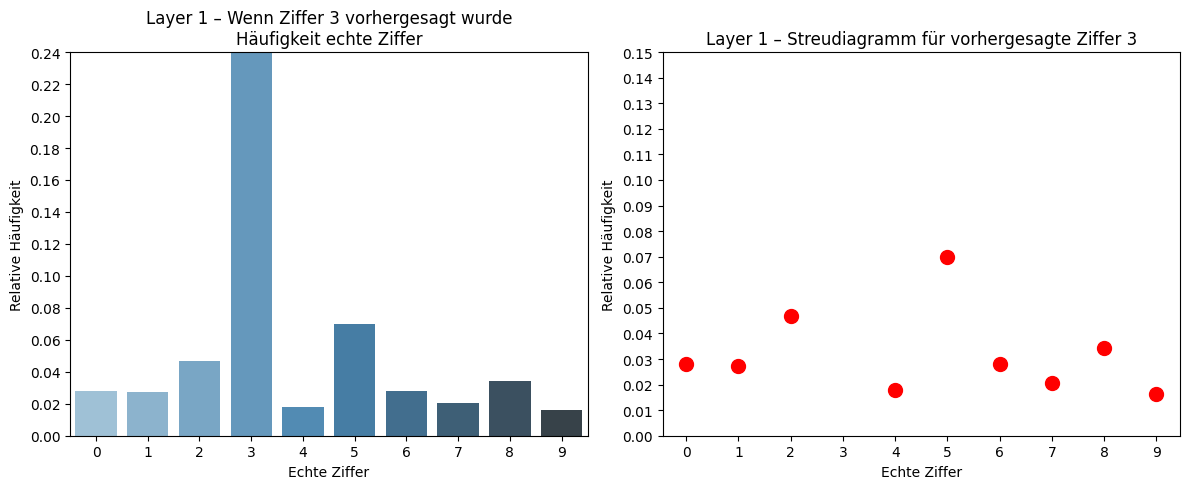

In [157]:
# Balken und Streudiagramm plotten für festgesetzten Layer
plot_diagrams(layer=1, ymax_bar=0.24, ystep_bar=0.02,
                     ymax_scatter=0.15, ystep_scatter=0.01)

In [ ]:
# Für weiteren Layer anschauen
plot_diagrams(layer=4, ymax_bar=0.24, ystep_bar=0.02,
                     ymax_scatter=0.15, ystep_scatter=0.01)

### Zum Abschluss stellen wir uns noch 2 Fragen: Was sieht das CNN? Was lernt das CNN?

In [198]:
def select_image_from_testset(seed=None):
    """Wählt ein Bild aus dem Testset. Mit seed reproduzierbar, ohne seed zufällig."""
    #Seed setzen mit Option auf None seed
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # Random Bild
    idx = random.randint(0, len(test_dataset)-1)
    image, label = test_dataset[idx]
    return image.unsqueeze(0), label



def get_model(model_dict, layer, lr, batch):
    """Lädt Modell mit Fehlerprüfung."""
    exp_name = f"L{layer}_LR{lr}_B{batch}" # Eindeutigen Namen zuordnen
    if exp_name not in model_dict:
        raise ValueError(
            f"Modell '{exp_name}' existiert nicht. "
            f"Hast du diesen Layer mit diesen Hyperparametern bereits trainiert?"
        )
    return model_dict[exp_name], exp_name   # gebe das Modell und den zugehörigen Namen zurück




# -----------------------------------------------------
# FEATURE MAPS
# -----------------------------------------------------

def plot_feature_maps(model_dict, layer, lr, batch, seed=None):
    """
    Zeigt die Feature Maps eines beliebigen Conv-Layers (1–5) für ein
    Bild aus dem Testset.
    """

    # Modell laden
    model, exp_name = get_model(model_dict, layer, lr, batch)
    model.eval()

    # Seed abrufen, Bild laden
    image, label = select_image_from_testset(seed)

    # Layer-Index innerhalb ModuleList halten
    layer_idx = layer - 1   # Verbraucher gibt 1–5 an, Python braucht 0–4

    if layer_idx >= model.num_conv_layers:
        raise ValueError(
            f"Modell {exp_name} hat nur {model.num_conv_layers} Convolutional Layers, "
            f"aber layer={layer} wurde angefordert."
        )

    activations = []

    # Hook-Funktion initialisieren
    def forward_hook(module, input, output):
        activations.append(output.detach())
    handle = model.convs[layer_idx].register_forward_hook(forward_hook)

    # Forward Pass
    _ = model(image)

    # Hook entfernen
    handle.remove()

    # Feature Maps extrahieren
    act = activations[0].squeeze(0)
    num_maps = act.shape[0]
    cols = 5
    rows = (num_maps + cols - 1) // cols

    # Plot anpassen
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, fmap in enumerate(act):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fmap.cpu(), cmap='viridis')
        plt.axis('off')

    plt.suptitle(f"Feature Maps – Layer {layer} ({exp_name}), Label={label}")
    plt.show()




# -----------------------------------------------------
# GRAD-CAM
# -----------------------------------------------------

def plot_grad_cam(model_dict, layer, lr, batch, seed=None, target_class=None):
    """
    Grad-CAM für einen beliebigen Conv-Layer 1–5.
    """

    # Modell laden
    model, exp_name = get_model(model_dict, layer, lr, batch)
    model.eval()

    # seed abrufen, Bild laden
    image, label = select_image_from_testset(seed)

    layer_idx = layer - 1
    if layer_idx >= model.num_conv_layers:
        raise ValueError(
            f"Modell {exp_name} besitzt nur {model.num_conv_layers} Convolutional Layers."
        )

    activations, gradients = [], []

    def forward_hook(module, input, output):
        # Speichert die Feature-Maps (Aktivierungen) des Layers während des Forward-Passes# Speichert die Feature-Maps (Aktivierungen) des Layers während des Forward-Passes
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        # Speichert die Gradienten des Layers während des Backward-Passes
        gradients.append(grad_out[0])

    # Hooks initialisieren
    handle_f = model.convs[layer_idx].register_forward_hook(forward_hook)
    handle_b = model.convs[layer_idx].register_backward_hook(backward_hook)

    output = model(image)

    if target_class is None:
        target_class = output.argmax(dim=1).item()  # Falls keine Zielklasse angegeben ist, vom Modell vorhergesagte Klasse nehmen

    # Backprop
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    # CAM Berechnung
    activation = activations[0].detach()
    gradient = gradients[0].detach()

    weights = gradient.mean(dim=(2, 3), keepdim=True)
    grad_cam_map = F.relu((weights * activation).sum(dim=1)).squeeze()
    grad_cam_map = grad_cam_map / grad_cam_map.max()

    # Hooks entfernen
    handle_f.remove()
    handle_b.remove()

    # Bild für Plot vorbereiten
    img = image[0].cpu()
    img = img * 0.5 + 0.5
    img = img.clamp(0, 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.imshow(grad_cam_map.cpu(), cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Grad-CAM – Layer {layer} ({exp_name}) | Label={label} | Target={target_class}")
    plt.show()

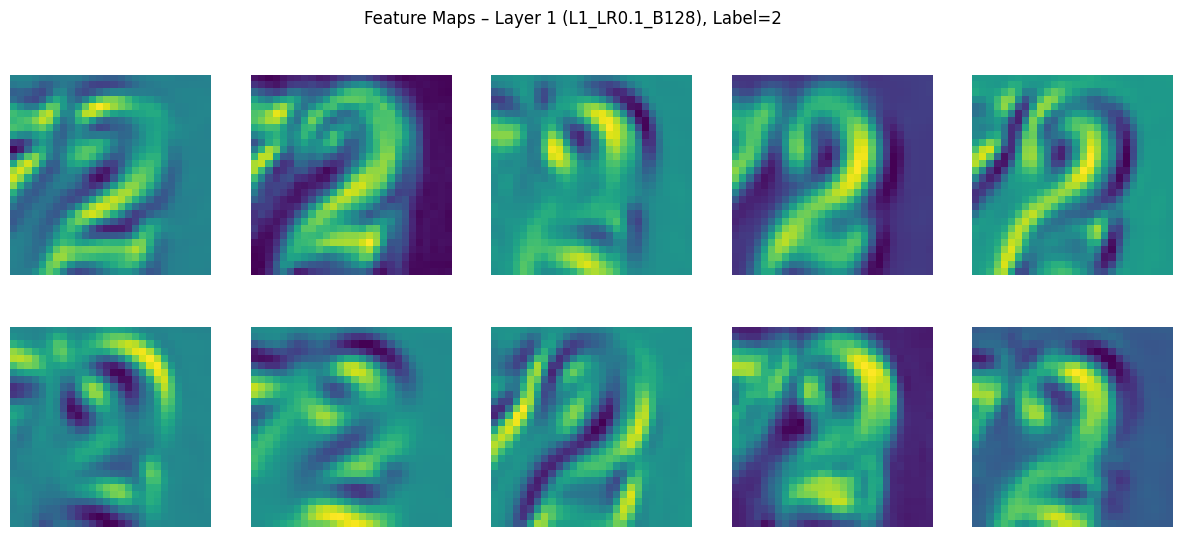

C:\Users\jfdde\PycharmProjects\CNN\.venv\lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


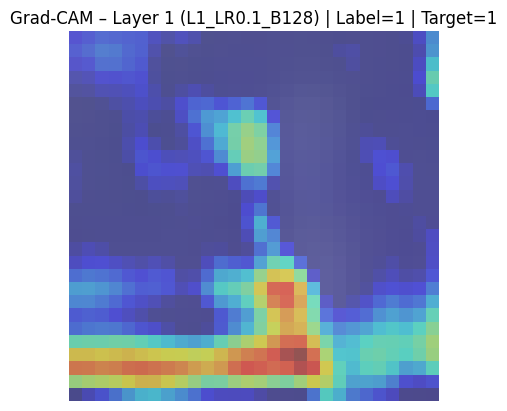

In [202]:
# Plotten
plot_feature_maps(model_dict=ALL_MODELS, layer=1, lr=0.1, batch=128, seed=None) # Was gelernt wird
plot_grad_cam(model_dict=ALL_MODELS, layer=1, lr=0.1, batch=128, seed=None) # Wo besonders vom Netz hingeschaut wird